# Aparna Ambarapu

In [1]:
import os
import datetime

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import plotnine as p9
import quandl
import seaborn as sns
import warnings

from mistune.markdown import preprocess

warnings.filterwarnings("ignore")

from functools import reduce
from scipy.stats import zscore
import statsmodels.api as sm

In [2]:
import json

# Load API key from a JSON file
with open("../../config.json", "r") as file:
    config = json.load(file)

api_key = config["api_key"]


In [3]:
folder_path = '/Users/aparnaambarapu/Downloads/qts/HW/HW3'

In [4]:
def grab_quandl_table(
    table_path,
    folder_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = os.path.join(folder_path)
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink

    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename=data_file, api_key=api_key, **kwargs
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, folder_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, folder_path, avoid_download=avoid_download, **kwargs)
    )

# Download relevant datasets
- ZACKS Fundamentals
    - FC (Fundamentals Condensed),
    - FR (Fundamentals Ratios)
    - MT (Master Table)
    - MKTV (Market Value Supplment)
    - SHRC (Shares Out supplement)
    - HDM (Historical Daily Maintenance)

QUOTEMEDIA/PRICES - EOD prices

In [5]:
qm_prices = fetch_quandl_table('QUOTEMEDIA/PRICES',folder_path, avoid_download=True)
z_fc = fetch_quandl_table('ZACKS/FC',folder_path, avoid_download=True)
z_fr = fetch_quandl_table('ZACKS/FR',folder_path, avoid_download=True)
z_mt = fetch_quandl_table('ZACKS/MT',folder_path, avoid_download=True)
z_mktv = fetch_quandl_table('ZACKS/MKTV',folder_path, avoid_download=True)
z_shrs = fetch_quandl_table('ZACKS/SHRS',folder_path, avoid_download=True)
z_hdm = fetch_quandl_table('ZACKS/HDM',folder_path, avoid_download=True)

Skipping any possible download of QUOTEMEDIA/PRICES
Skipping any possible download of ZACKS/FC
Skipping any possible download of ZACKS/FR
Skipping any possible download of ZACKS/MT
Skipping any possible download of ZACKS/MKTV
Skipping any possible download of ZACKS/SHRS
Skipping any possible download of ZACKS/HDM


# Filter Functions
1) Data over the entire period Jan 2017 through Jun 2024 with adj_close available - **1884 dates** and **20862 tickers**
2) Market value never dips below $1MM - **3584 tickers**
3) debt/market cap ratio is greater than 0.1 somewhere in the period - **3117 tickers**
4) not in the automotive, financial or insurance sector - **2319 tickers**
5) has feasible calculation of the ratios: debt to market cap, return on investment, price to earnings - **697 tickers** (with non-NaN values for all 30 quarterly date entries, non-NaN filing dates, and eps<=0)

In [6]:
def filter_data(df, start_date, end_date, date_col = 'date'):
    df['date'] = pd.to_datetime(df[date_col])
    filtered_df = df[(df[date_col] >= start_date) & (df[date_col] <= end_date)]
    filtered_df=filtered_df.sort_values(by=date_col).reset_index(drop=True)
    return filtered_df

def clean_data(df, final_cols):
    df = df[df['per_type']=='Q'][final_cols]
    return df

def calculate_debt(net_lterm_debt, tot_lterm_debt):
    if not pd.isna(net_lterm_debt):
        return net_lterm_debt
    elif not pd.isna(tot_lterm_debt):
        return tot_lterm_debt
    else:
        return 0.0

def compute_eps(row):
    eps = row['eps_diluted_net'] if not pd.isnull(row['eps_diluted_net']) else row['basic_net_eps']
    if eps is not None and eps < 0:
        eps = 0.001
    return eps

def fill_within_one_year(df, cols):
    df = df.sort_values(by='per_end_date')

    for col in cols:
        # Iterate through rows and fill NaN values based on a 1-year window
        for i in range(len(df)):
            if pd.isna(df.at[i, col]):  # Check if the current value is NaN
                # Find rows within the last year
                valid_values = df.loc[
                    (df['per_end_date'] <= df.at[i, 'per_end_date']) &
                    (df['per_end_date'] > df.at[i, 'per_end_date'] - pd.DateOffset(years=1)),
                    col
                ]
                if not valid_values.empty:
                    # Fill with the most recent valid value within 1 year
                    df.at[i, col] = valid_values.iloc[-1]
    return df

# Drop any ticker that still has NaN values in final_cols and incomplete data (< 30 entries for the period Jan 2017 to Jun 2024)
def drop_incomplete_tickers(df, final_cols):
    incomplete_tickers = df[df[final_cols].isnull().any(axis=1)]['ticker'].unique()
    cleaned_df = df[~df['ticker'].isin(incomplete_tickers)]
    cleaned_df = cleaned_df.groupby('ticker').filter(lambda x: len(x) >= 30)
    return cleaned_df

In [7]:
qm_prices_filtered = filter_data(qm_prices, '2017-01-01', '2024-06-30').dropna(subset=['adj_close'])[['date','ticker', 'adj_close']]

In [8]:
#1
tickers_so_far = (qm_prices_filtered['ticker'].unique())
print('Tickers: ', len(tickers_so_far)) #
print('Dates: ',len(qm_prices_filtered['date'].unique()))

Tickers:  20862
Dates:  1884


In [9]:
#2
z_mktv_filtered = filter_data(z_mktv, '2017-01-01', '2024-06-30', date_col = 'per_end_date')
z_mktv_filtered = z_mktv_filtered.groupby('ticker').filter(lambda x: (x['mkt_val'] > 1).all())

tickers_so_far = (z_mktv_filtered['ticker'].unique())
print('Tickers: ',len(tickers_so_far)) #

Tickers:  3584


In [10]:
#3
z_fr_filtered = filter_data(z_fr, '2017-01-01', '2024-06-30', 'per_end_date')
z_fr_filtered = z_fr_filtered[(z_fr_filtered['ticker'].isin(tickers_so_far) & ((z_fr_filtered['tot_debt_tot_equity'] > 0.1)))]

tickers_so_far = (z_fr_filtered['ticker'].unique())
print('Tickers: ',len(tickers_so_far)) #

Tickers:  3117


### Sanity checks #1

In [11]:
for t in ['AMZN', 'FLEX', 'MLAB', 'POOL', 'TILE', 'WYNN']:
    if t in tickers_so_far:
        print(t, ' exists')
    else:
        print(t, ' doesnt exists')

AMZN  exists
FLEX  exists
MLAB  exists
POOL  exists
TILE  exists
WYNN  exists


In [12]:
#4
z_fc_filtered = filter_data(z_fc, '2017-01-01', '2024-06-30', 'per_end_date')
z_fc_filtered = z_fc_filtered[(z_fc_filtered['ticker'].isin(tickers_so_far)) & (~z_fc_filtered['zacks_sector_code'].isin([5.0, 13.0]))]

tickers_so_far = (z_fc_filtered['ticker'].unique())
print('Tickers: ',len(tickers_so_far)) #

Tickers:  2319


In [13]:
z_shrs_filtered =  filter_data(z_shrs, '2017-01-01', '2024-06-30', 'per_end_date')
z_shrs_filtered=z_shrs_filtered[z_shrs_filtered['ticker'].isin(tickers_so_far)]

tickers_so_far = (z_shrs_filtered['ticker'].unique())
print('Tickers: ',len(tickers_so_far))

Tickers:  2319


In [14]:
common_lst = ['per_end_date','ticker']
fr_cols_list  = common_lst+ ['ret_invst', 'tot_debt_tot_equity']
fc_cols_list = common_lst+ ['net_lterm_debt','tot_lterm_debt', 'eps_diluted_net', 'basic_net_eps', 'filing_date', 'zacks_sector_code', 'tot_revnu']
mkvt_cols_list = common_lst+ ['mkt_val']
shrs_cols_list = common_lst+ ['shares_out']

In [15]:
z_fr_filtered = clean_data(z_fr_filtered, fr_cols_list)
z_fc_filtered = clean_data(z_fc_filtered, fc_cols_list)
z_mktv_filtered = clean_data(z_mktv_filtered, mkvt_cols_list)
z_shrs_filtered = clean_data(z_shrs_filtered, shrs_cols_list)

In [16]:
merged_df = reduce(lambda left, right: pd.merge(left,
        right, on=common_lst, how='inner'), [z_fc_filtered, z_shrs_filtered, z_mktv_filtered, z_fr_filtered]).drop_duplicates()

In [17]:
len(merged_df['ticker'].unique())

2002

In [18]:
merged_df['per_end_date'] = pd.to_datetime(merged_df['per_end_date'])
merged_df['filing_date'] = pd.to_datetime(merged_df['filing_date'])
merged_df = fill_within_one_year(merged_df, ['net_lterm_debt', 'tot_lterm_debt',
       'eps_diluted_net', 'basic_net_eps', 'tot_revnu', 'shares_out', 'mkt_val', 'ret_invst', 'tot_debt_tot_equity'])

In [19]:
merged_df['debt'] = merged_df.apply(lambda row: calculate_debt(row['net_lterm_debt'], row['tot_lterm_debt']), axis=1)
merged_df['investment'] = merged_df['mkt_val']+merged_df['debt']
merged_df['final_eps'] = merged_df.apply(compute_eps, axis=1)
merged_df = merged_df.drop(['net_lterm_debt', 'tot_lterm_debt', 'eps_diluted_net', 'basic_net_eps', 'zacks_sector_code', 'tot_revnu'], axis=1)

In [20]:
merged_df = drop_incomplete_tickers(merged_df, ['ret_invst', 'filing_date'])
merged_df.isna().sum()

per_end_date           0
ticker                 0
filing_date            0
shares_out             0
mkt_val                0
ret_invst              0
tot_debt_tot_equity    0
debt                   0
investment             0
final_eps              0
dtype: int64

In [21]:
tickers_to_exclude = merged_df[merged_df['final_eps'] <= 0]['ticker'].unique()
merged_df = merged_df[~merged_df['ticker'].isin(tickers_to_exclude)]

In [22]:
merged_df.shape #697 tickers * 30 dates

(20910, 10)

### Sanity Checks #2


In [23]:
for t in ['AMZN', 'CAT', 'FLEX', 'POOL', 'SUN']:
    if t in merged_df['ticker'].unique():
        print(t, ' exists')
    else:
        print(t, ' doesnt exists')

AMZN  exists
CAT  exists
FLEX  exists
POOL  exists
SUN  exists


# Daily Data creation

In [24]:
# merged_df['trade_date'] = merged_df['per_end_date'].apply(lambda x: x if x.weekday() < 5 else x - BusinessDay(1))
merged_df['effective_date']= merged_df['filing_date'] + pd.Timedelta(days=1)

In [25]:
qm_prices_filtered = qm_prices_filtered.sort_values('date')
merged_df = merged_df.sort_values('per_end_date')

# Perform asof merge to align filing dates with the most recent daily price
price_per_end_date = pd.merge_asof(
    merged_df,
    qm_prices_filtered,
    left_on='per_end_date',
    right_on='date',
    by='ticker',
    direction='backward'  # Ensures no lookahead; aligns with the most recent past date
)[['per_end_date', 'ticker', 'adj_close']]

In [26]:
price_per_end_date.shape

(20910, 3)

In [27]:
qm_prices_filtered = qm_prices_filtered.sort_values('date')
merged_df = merged_df.sort_values('effective_date')
final_df = pd.merge_asof(
    qm_prices_filtered,
    merged_df,
    left_on='date',
    right_on='effective_date',
    by='ticker',  # Match on ticker as well
    direction='backward'
)

In [28]:
final_df = final_df.merge(price_per_end_date.rename(columns={'adj_close':'prev_price'}), on = ['per_end_date', 'ticker'], how='left')

#### Sanity checks #3
data matching with **6.0.1 SEC Reports** in the assignment

In [29]:
final_df[((final_df['ticker']=='WM') & (final_df['per_end_date']).isin(['2023-06-30', '2023-09-30', '2023-12-31', '2024-03-31', '2024-06-30', '2024-09-30']))][['per_end_date','filing_date', 'final_eps', 'debt', 'tot_debt_tot_equity', 'ret_invst', 'shares_out', 'mkt_val']].drop_duplicates()

,per_end_date,filing_date,final_eps,debt,tot_debt_tot_equity,ret_invst,shares_out,mkt_val
16997642,2023-06-30,2023-07-26,1.51,282.0,2.2182,2.8141,405.06,70245.41
17706637,2023-09-30,2023-10-25,1.63,328.0,2.2150,2.9956,402.77,61399.09
18524190,2023-12-31,2024-02-13,1.22,912.0,2.3534,2.0578,402.77,72137.08
19065338,2024-03-31,2024-04-25,1.75,-158.0,2.2744,3.0954,401.08,85490.86


In [30]:
final_df= final_df.dropna()

In [31]:
final_df['debt_to_market_cap_final'] = final_df['tot_debt_tot_equity']*final_df['prev_price']/final_df['adj_close']
final_df['return_on_inv_final'] = final_df['ret_invst']*final_df['investment']/(final_df['debt']+(final_df['mkt_val']*final_df['adj_close']/final_df['prev_price']))
final_df['price_to_earnings_final'] = final_df['adj_close']/final_df['final_eps']

#### Sanity Check #4
data matching with **6.0.2 Ratios On Key Dates** in the assignment

![image](image__2.png)

In [32]:
final_df[((final_df['ticker']=='WM') & (final_df['date']).isin(['2022-10-26', '2022-10-27', '2022-12-30', '2023-01-03', '2023-02-07', '2023-02-08', '2023-03-31', '2023-04-03', '2023-04-27', '2023-04-28', '2023-06-30', '2023-07-03', '2023-07-26', '2023-07-27', '2023-09-29', '2023-10-02', '2023-10-25', '2023-10-26', '2023-12-29', '2024-01-02', '2024-02-13', '2024-02-14', '2024-03-28', '2024-04-01', '2024-04-25', '2024-04-26', '2024-06-28', '2024-07-01', '2024-07-25', '2024-07-26']))][['date','debt_to_market_cap_final','return_on_inv_final', 'price_to_earnings_final']]

,date,debt_to_market_cap_final,return_on_inv_final,price_to_earnings_final
14803134,2022-10-26,1.891277,2.634588,109.896458
14824981,2022-10-27,2.029799,3.106361,99.569072
15350957,2022-12-30,2.040269,3.122265,99.058098
15366761,2023-01-03,2.038320,3.119305,99.152812
15651976,2023-02-07,2.115096,3.235886,95.553684
15669204,2023-02-08,2.270112,2.423785,121.236072
16090334,2023-03-31,2.089139,2.234389,131.738209
16100010,2023-04-03,2.080215,2.225033,132.303367
16291243,2023-04-27,2.109044,2.255253,130.494863
16305715,2023-04-28,2.218444,2.393665,124.782115


# Exploratory analysis

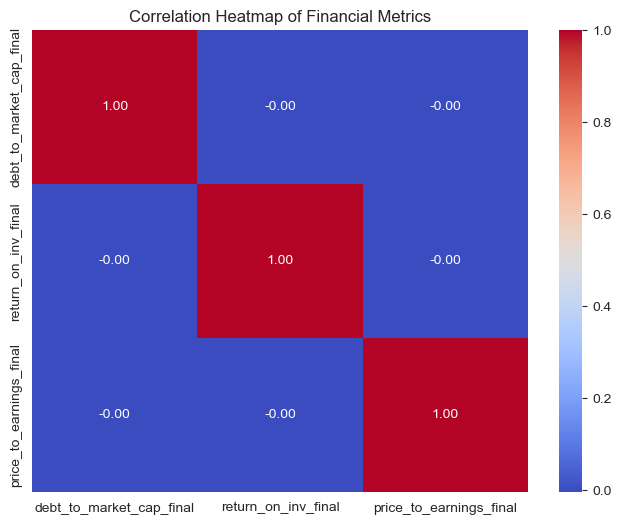

In [33]:
correlation_matrix = final_df[['debt_to_market_cap_final', 'return_on_inv_final', 'price_to_earnings_final']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Correlation Heatmap of Financial Metrics')
plt.show()


Correlation between ratios directly doesn't give us much information, as the tickers are diverse and highly skewed with large-cap companies as outliers.

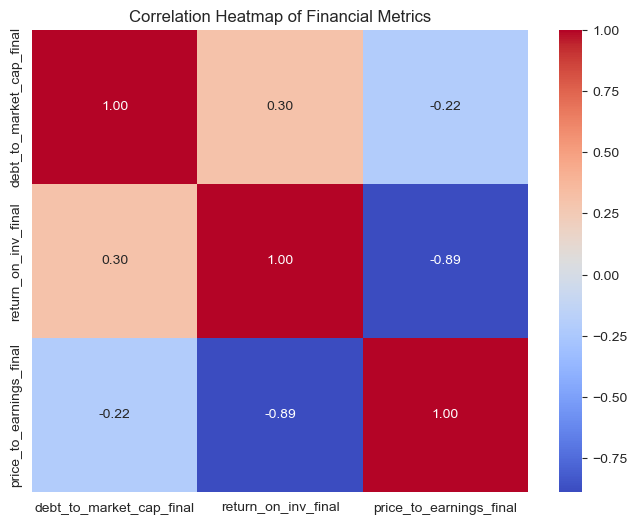

In [34]:
median_by_date = final_df.groupby('date')[['debt_to_market_cap_final', 'return_on_inv_final', 'price_to_earnings_final']].median()
correlation_matrix = median_by_date.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Correlation Heatmap of Financial Metrics')
plt.show()


Using Medians help us to understand the correlations better. Highest positive correlation is between debt_to_mkt_cap and return_on_inv, negative correlation between return_on_inv and price_to_earnings - when price/earnings is high, that means that the company is over valued and can have low returns on invested capital.

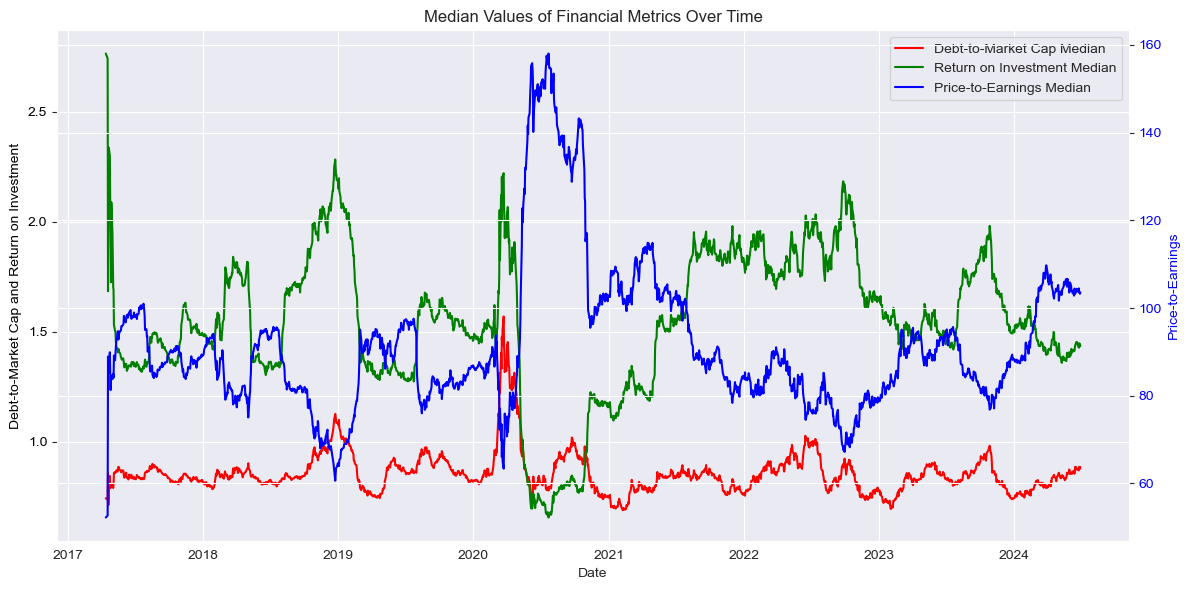

In [35]:
fig, ax1 = plt.subplots(figsize=(12, 6))

color1 = 'red'
color2 = 'green'
ax1.set_xlabel('Date')
ax1.set_ylabel('Debt-to-Market Cap and Return on Investment', color='black')
ax1.plot(median_by_date.index, median_by_date['debt_to_market_cap_final'], label='Debt-to-Market Cap Median', color=color1)
ax1.plot(median_by_date.index, median_by_date['return_on_inv_final'], label='Return on Investment Median', color=color2)
ax1.tick_params(axis='y', labelcolor='black')

ax2 = ax1.twinx()
color3 = 'blue'
ax2.set_ylabel('Price-to-Earnings', color=color3)
ax2.plot(median_by_date.index, median_by_date['price_to_earnings_final'], label='Price-to-Earnings Median', color=color3)
ax2.tick_params(axis='y', labelcolor=color3)

plt.title('Median Values of Financial Metrics Over Time')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

plt.tight_layout()
plt.show()


All financial ratios have high volatility and huge spikes in 2020, which alings with the market conditions during pandemic.

## Combined score
I tried to come up with a combined scores using normalised debt_to_mkt_cap, return_on_inv and inverse price_per_earnings ratios as independent variables trying to predict one month forward return (from adj_close prices) using Linear Regression.

In [36]:
def calculate_forward_returns(df, days_forward=20):
    df = df.sort_values(['ticker', 'date']).reset_index(drop=True)
    # Calculate forward returns for each ticker
    df['forward_returns'] = df.groupby('ticker')['adj_close'].shift(-days_forward) / df['adj_close'] - 1
    df.dropna(subset=['forward_returns'], inplace=True)
    return df

def calculate_deterministic_weights(df, days_forward=20):
    df = calculate_forward_returns(df, days_forward=days_forward)

    # Normalize independent variables by z-score within each ticker
    df['debt_norm'] = df.groupby('ticker')['debt_to_market_cap_final'].transform(zscore)
    df['roi_norm'] = df.groupby('ticker')['return_on_inv_final'].transform(zscore)
    df['pe_norm'] = df.groupby('ticker')['price_to_earnings_final'].transform(zscore)

    # Avoid division errors for P/E inverse
    df['pe_inv'] = np.where(df['price_to_earnings_final'] != 0, 1 / df['price_to_earnings_final'], 0)

    X = df[['debt_norm', 'roi_norm', 'pe_inv']].values
    y = df['forward_returns'].values
    weights, _, _, _ = np.linalg.lstsq(X, y, rcond=None)

    return weights

def create_combined_score(df, weights):
    # Normalize ratios using z-score
    df['debt_norm'] = zscore(df['debt_to_market_cap_final'])
    df['roi_norm'] = zscore(df['return_on_inv_final'])
    df['pe_norm'] = zscore(df['price_to_earnings_final'])

    # Avoid division errors by ensuring P/E normalization is safe
    # df['pe_inv'] = np.where(df['pe_norm'] != 0, 1 / df['pe_norm'], 0)
    df['pe_inv'] = np.where(df['price_to_earnings_final'] != 0, 1 / df['price_to_earnings_final'], 0)

    # Composite score calculation
    df['composite_score'] = weights[0] * df['debt_to_market_cap_final'] + weights[1] * df['return_on_inv_final'] + weights[2] * df['pe_inv']
    return df


In [37]:
weights = calculate_deterministic_weights(final_df, days_forward=20)
final_df = create_combined_score(final_df, weights)

## Loading SPY for benchmark

In [38]:
import yfinance as yf
spy_data = yf.download('SPY', start='2017-01-01', end='2025-01-31')

[*********************100%***********************]  1 of 1 completed


In [39]:
spy_data.to_csv('spy_historical_data.csv')

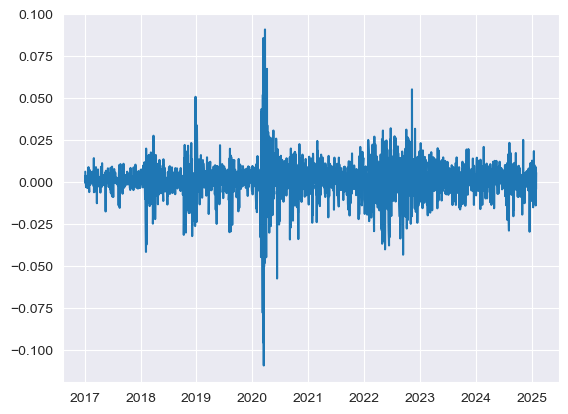

In [40]:
spy_data['spy_returns'] = spy_data['Close'].pct_change()
plt.plot(spy_data.index, spy_data['spy_returns'])
plt.show()

# Decile trading strategy

The top-and-bottom decile trading strategy ranks tickers based on selected ratios or their combinations, assuming higher-ranked tickers perform better. At each rebalancing, the strategy goes long on top-decile tickers and short on bottom-decile tickers, with position sizes adjusted to maintain equal capital allocation for long and short positions relative to the initial capital.

* Monthly and Weekly rebalancing performance of four financial ratios
    - Performance metrics, Cumulative returns and Cumulative PnL plots (Comparing all four ratios)
* Changes in ratios performance with sizing positions by rank (doubling or halving the most “attractive” vigintiles)
    - Performance metrics, Cumulative returns and Cumulative PnL plots (Comparing when using direct ratio changes, doubling sizes, halving sizes)

In [41]:
columns_to_process = ['debt_to_market_cap_final', 'return_on_inv_final', 'price_to_earnings_final', 'composite_score']
final_df[columns_to_process] = final_df[columns_to_process].replace([np.inf, -np.inf], np.nan).fillna(final_df[columns_to_process].mean())

In [42]:
def get_pivot_table(df, col_name):
    df_pivot = df.pivot(index='date', columns='ticker', values=col_name)
    df_pivot = df_pivot.apply(lambda col: col.fillna(col.mean()), axis=0)
    return df_pivot

def calculate_quantiles(df_ratio, n_tickets, quantile, ascending):
    df_ratio_rank = df_ratio.rank(axis=1, ascending=ascending).astype(int)
    buy_quantile = int(quantile * n_tickets)
    sell_quantile = n_tickets - buy_quantile + 1
    return df_ratio_rank, buy_quantile, sell_quantile

def generate_positions(df_ratio_rank, buy_quantile, sell_quantile):
    def position(q):
        if q <= buy_quantile:
            return 1
        elif q >= sell_quantile:
            return -1
        else:
            return 0
    return df_ratio_rank.applymap(position)

# Set initial capital to be 10 times the gross notional of your first month’s set of positions.
def calculate_initial_capital(df_position, df_adj_close):
    first_month_long = list(df_position.columns[df_position.iloc[0] == 1])
    first_month_short = list(df_position.columns[df_position.iloc[0] == -1])

    first_month_long_capital = sum(df_adj_close.iloc[0][first_month_long])
    first_month_short_capital = sum(df_adj_close.iloc[0][first_month_short])

    initial_capital = (first_month_long_capital + first_month_short_capital) * 10
    return initial_capital, initial_capital / 2

def adjust_positions(df_position, df_adj_close, capital):
    df_position_adjusted = df_position.copy()

    for index, row in df_position.iterrows():
        month_long = list(df_position.columns[df_position.loc[index] == 1])
        month_short = list(df_position.columns[df_position.loc[index] == -1])

        month_long_capital = sum(df_adj_close.loc[index][month_long])
        month_short_capital = sum(df_adj_close.loc[index][month_short])

        long_ratio = capital * (1 / month_long_capital) if month_long_capital != 0 else 0
        short_ratio = capital * (1 / month_short_capital) if month_short_capital != 0 else 0

        df_position_adjusted.loc[index] = df_position.loc[index].map(
            lambda x: long_ratio if x == 1 else (-1 * short_ratio if x == -1 else x))

    return df_position_adjusted

def apply_frequency_rebalancing(df_position_adjusted, frequency):
    if frequency == 'D':
        return df_position_adjusted
    df_position_adjusted['date'] = pd.to_datetime(df_position_adjusted.index)
    df_position_adjusted['freq_start'] = (
        df_position_adjusted['date'].dt.to_period(frequency).apply(lambda r: r.start_time)
    )
    df_position_adjusted['new_position'] = (
        df_position_adjusted['freq_start'] == df_position_adjusted['date']
    )

    mask_new_positions = ~df_position_adjusted['new_position']

    for col in df_position_adjusted.columns[:-3]:
        # Replace non-rebalancing rows with NaN
        df_position_adjusted[col] = np.where(mask_new_positions, np.nan, df_position_adjusted[col])

    # Forward-fill to propagate positions until the next rebalancing date
    df_position_adjusted.fillna(method='ffill', inplace=True)
    df_position_adjusted.drop(columns=['date', 'freq_start', 'new_position'], inplace=True)

    return df_position_adjusted

def calculate_pnl_and_returns(df_position_adjusted, df_adj_close, initial_capital):
    r = 3.5 * 0.01  # fixed funding rate
    repo_rate_daily = (r - 100 * 1e-4) / 252  # repo rate = funding rate - 100bp

    pnl_data = {
        'date': [],
        'pnl': [],
        'cumulative_pnl': [],
        'cumulative_return': [],
        'net_ret': [],
        'cumulative_net_ret': []
    }

    cumulative_pnl = 0.0
    cumulative_net_ret = 1.0

    for i in range(12, len(df_adj_close)):
        # Extract date for the current iteration
        current_date = df_adj_close.index[i]

        # Calculate daily PnL
        pnl_components = df_position_adjusted.iloc[i - 1] * (
            df_adj_close.iloc[i] - df_adj_close.iloc[i - 1]
        )
        pnl = pnl_components.sum()

        # Update cumulative PnL
        cumulative_pnl += float(pnl)

        # Calculate daily return
        ret = pnl / initial_capital

        # Apply repo rate only to short positions
        short_positions = df_position_adjusted.iloc[i - 1] < 0
        short_costs = abs(df_position_adjusted.iloc[i - 1][short_positions]) * repo_rate_daily
        net_ret = ret + short_costs.sum() / initial_capital

        cumulative_return = cumulative_pnl / initial_capital
        cumulative_net_ret *= (net_ret + 1)

        # Append results to pnl_data
        pnl_data['date'].append(current_date)
        pnl_data['pnl'].append(pnl)
        pnl_data['cumulative_pnl'].append(cumulative_pnl)
        pnl_data['cumulative_return'].append(cumulative_return)
        pnl_data['net_ret'].append(net_ret)
        pnl_data['cumulative_net_ret'].append(cumulative_net_ret)

    # Create DataFrame for PnL data with dates as index
    pnl_df = pd.DataFrame(pnl_data)
    pnl_df.set_index('date', inplace=True)  # Set date as the index

    return pnl_df

In [43]:
def quantile_trading_pipeline(df, ratio_column, quantile=0.1,
                              frequency='M', ascending=False):
    n_ticker = df['ticker'].nunique()
    # Preprocess data
    df_adj_close = get_pivot_table(df, 'adj_close')
    df_ratio = get_pivot_table(df, ratio_column)
    # Calculate quantiles and rank ratios
    df_ratio_rank, buy_quantile, sell_quantile = calculate_quantiles(
        df_ratio, n_ticker, quantile, ascending)
    # Generate positions
    df_position = generate_positions(df_ratio_rank, buy_quantile, sell_quantile)
    # Calculate initial capital and capital for a side
    initial_capital, capital = calculate_initial_capital(df_position, df_adj_close)
    # Adjust positions based on capital constraints
    df_position_adjusted = adjust_positions(df_position, df_adj_close, capital)
    # Apply frequency-based rebalancing
    df_position_adjusted = apply_frequency_rebalancing(df_position_adjusted, frequency)
    # Calculate PnL and returns
    pnl_df = calculate_pnl_and_returns(df_position_adjusted, df_adj_close, initial_capital)
    return pnl_df


In [44]:
def performance_metrics(ratio_dfs):
    combined_metrics = pd.DataFrame()
    cumulative_returns_list = []
    cumulative_pnl_list = []

    for ratio, df in ratio_dfs.items():
        returns = df['net_ret'].to_frame()
        cumulative_returns = df['cumulative_net_ret'].to_frame()
        cumulative_pnl = df['cumulative_pnl'].to_frame()

        metrics = pd.DataFrame(index=[ratio])
        metrics['Mean'] = round(returns.mean().iloc[0], 6)
        metrics['Vol'] = round(returns.std().iloc[0], 6)
        metrics['Sharpe'] = round(metrics['Mean'] / metrics['Vol'], 4) if metrics['Vol'].iloc[0] != 0 else 0

        metrics['Min'] = round(cumulative_returns.min().iloc[0], 6)
        metrics['Max'] = round(cumulative_returns.max().iloc[0], 6)

        rolling_max = cumulative_returns['cumulative_net_ret'].rolling(len(cumulative_returns), min_periods=1).max()
        drawdown = cumulative_returns['cumulative_net_ret'] - rolling_max
        metrics['Max Drawdown'] = round(drawdown.min(), 6)
        confidence_level = 0.05
        var_95 = np.percentile(returns.values, confidence_level * 100)
        metrics['VaR (5%)'] = round(var_95, 6)
        cvar_95 = returns[returns <= var_95].mean().iloc[0]
        metrics['CVaR (5%)'] = round(cvar_95, 6)

        combined_metrics = pd.concat([combined_metrics, metrics])
        cumulative_returns_list.append((ratio, cumulative_returns))
        cumulative_pnl_list.append((ratio, cumulative_pnl))
    return combined_metrics, cumulative_returns_list, cumulative_pnl_list

def plot_cumulative_returns(cumulative_returns_list):
    plt.figure(figsize=(12, 6))
    for ratio, cumulative_returns in cumulative_returns_list:
        plt.plot(cumulative_returns.index, cumulative_returns['cumulative_net_ret'], label=ratio)
    plt.title("Cumulative Net Returns")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Net Return (%)")
    plt.legend()
    plt.show()

def plot_cumulative_pnl(cumulative_pnl_list):
    plt.figure(figsize=(12, 6))
    for ratio, cumulative_pnl in cumulative_pnl_list:
        plt.plot(cumulative_pnl.index, cumulative_pnl['cumulative_pnl'], label=ratio)
    plt.title("Cumulative PnL")
    plt.xlabel("Date")
    plt.ylabel("Cumulative PnL")
    plt.legend()
    plt.show()

In [45]:
def calculate_downside_beta(strategy_returns, spy_returns, threshold=0):
    # Ensure returns are aligned
    combined_returns = pd.concat([strategy_returns, spy_returns], axis=1)
    combined_returns.columns = ['strategy', 'spy']
    combined_returns.dropna(inplace=True)

    downside_mask = combined_returns['spy'] < threshold
    downside_data = combined_returns[downside_mask]

    if len(downside_data) > 0:
        cov_down = np.cov(downside_data['strategy'], downside_data['spy'])[0, 1]
        var_down = np.var(downside_data['spy'])
        downside_beta = cov_down / var_down if var_down != 0 else np.nan
    else:
        downside_beta = np.nan
    return downside_beta

def calculate_all_downside_betas(ratio_dfs, spy_df, net_ret_column='net_ret', spy_return_column='spy_returns', threshold=0):
    spy_returns = spy_df[spy_return_column]
    downside_betas = {}
    for strategy_name, df in ratio_dfs.items():
        strategy_returns = df[net_ret_column]
        aligned_data = pd.concat([strategy_returns, spy_returns], axis=1).dropna()
        beta = calculate_downside_beta(aligned_data.iloc[:, 0], aligned_data.iloc[:, 1], threshold)
        downside_betas[strategy_name] = beta
    return downside_betas


### Monthly rebalancing

In [46]:
pnl_df_1 = quantile_trading_pipeline(
    df=final_df,
    ratio_column='debt_to_market_cap_final',
    quantile=0.1,
    frequency='M',
    ascending=False
)
pnl_df_2 = quantile_trading_pipeline(
    df=final_df,
    ratio_column='return_on_inv_final',
    quantile=0.1,
    frequency='M',
    ascending=False
)
pnl_df_3 = quantile_trading_pipeline(
    df=final_df,
    ratio_column='price_to_earnings_final',
    quantile=0.1,
    frequency='M',
    ascending=False
)
pnl_df_4 = quantile_trading_pipeline(
    df=final_df,
    ratio_column='composite_score',
    quantile=0.1,
    frequency='M',
    ascending=False
)

In [47]:
dict_dfs = {'debt_to_market_cap_final': pnl_df_1, 'return_on_inv_final':pnl_df_2, 'price_to_earnings_final':pnl_df_3,'composite_score':pnl_df_4}
combined_metrics, cumulative_returns_list, cumulative_pnl_list = performance_metrics(dict_dfs)

In [48]:
combined_metrics

,Mean,Vol,Sharpe,Min,Max,Max Drawdown,VaR (5%),CVaR (5%)
debt_to_market_cap_final,0.001194,0.048731,0.0245,0.996781,5.016384,-2.274225,-0.011221,-0.031042
return_on_inv_final,0.000028,0.054440,0.0005,-2.194721,0.988716,-3.183437,-0.031189,-0.094760
price_to_earnings_final,0.000351,0.058865,0.0060,0.253327,4.505042,-4.251715,-0.039875,-0.068093
composite_score,0.000600,0.052892,0.0113,0.656451,4.780402,-4.123950,-0.028744,-0.057082


In [49]:
downside_betas = calculate_all_downside_betas(dict_dfs, spy_data)
print("Downside Betas:")
print(downside_betas)

Downside Betas:
{'debt_to_market_cap_final': 0.17459178724063618, 'return_on_inv_final': -0.09631091634898399, 'price_to_earnings_final': 0.07491979907509914, 'composite_score': 0.10938321994678428}


The downside beta results show that the strategies are generally resilient during market downturns:
- **debt_to_market_cap_final**: Slightly sensitive to SPY's negative returns; for every 1% drop in SPY, this strategy decreases by ~0.17%.
- **return_on_inv_final**: Moves opposite to SPY during downturns, increasing by ~0.10% for every 1% drop in SPY, acting as a potential hedge.
- **price_to_earnings_final**: Very weak sensitivity to SPY's negative returns; defensive during market declines.
- **composite_score**: Moderately sensitive to SPY's negative returns, balancing resilience and sensitivity.

Takeaway:
Your strategies are low-risk during market downturns, with return_on_inv_final offering diversification benefits and others providing stability against broader market declines.

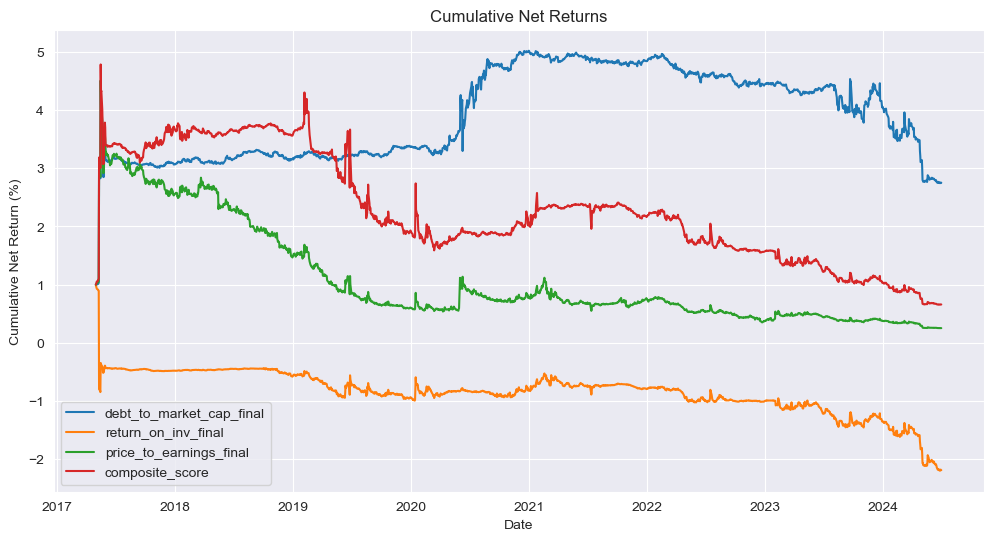

In [50]:
plot_cumulative_returns(cumulative_returns_list)

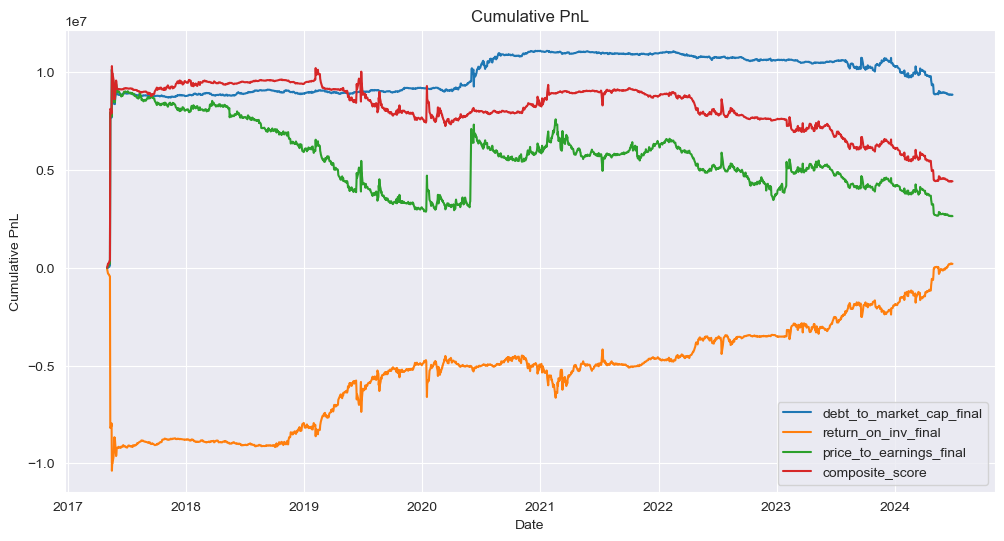

In [51]:
plot_cumulative_pnl(cumulative_pnl_list)

Debt to market cap performs better than other ratios. Composite score performs better than ROI or PPE
1. **Debt-to-Market-Cap Outperformance**:
   - Going long on high debt-to-market-cap companies worked because these firms likely benefited from favorable market conditions, such as post-COVID recovery (2020-2021) and fiscal stimulus. High-debt companies often thrive in bullish markets due to their leveraged nature, amplifying returns during growth periods.
   - However, the decline in performance post-2023 reflects the impact of rising interest rates and tighter credit conditions, which disproportionately hurt highly leveraged companies.
2. **Return on Investment**:
   - The flat-to-declining performance of this strategy suggests that return on investment (ROI) was less predictive of returns in recent years. This could be due to earnings volatility or market focus shifting away from profitability metrics during uncertain periods, such as the COVID crisis or inflationary pressures.
3. **Price-to-Earnings Final**:
   - Similar to ROI, price-to-earnings (P/E) ratios may have been less effective due to distorted earnings during economic disruptions and recovery phases.

### Weekly rebalancing

In [52]:
pnl_df_1 = quantile_trading_pipeline(
    df=final_df,
    ratio_column='debt_to_market_cap_final',
    quantile=0.1,
    frequency='W',
    ascending=False
)
pnl_df_2 = quantile_trading_pipeline(
    df=final_df,
    ratio_column='return_on_inv_final',
    quantile=0.1,
    frequency='W',
    ascending=False
)
pnl_df_3 = quantile_trading_pipeline(
    df=final_df,
    ratio_column='price_to_earnings_final',
    quantile=0.1,
    frequency='W',
    ascending=False
)
pnl_df_4 = quantile_trading_pipeline(
    df=final_df,
    ratio_column='composite_score',
    quantile=0.1,
    frequency='W',
    ascending=False
)

In [53]:
dict_dfs = {'debt_to_market_cap_final': pnl_df_1, 'return_on_inv_final':pnl_df_2, 'price_to_earnings_final':pnl_df_3, 'composite_score':pnl_df_4}
combined_metrics, cumulative_returns_list, cumulative_pnl_list = performance_metrics(dict_dfs)

In [54]:
combined_metrics

,Mean,Vol,Sharpe,Min,Max,Max Drawdown,VaR (5%),CVaR (5%)
debt_to_market_cap_final,0.000989,0.046558,0.0212,0.996781,4.524361,-2.349589,-0.012069,-0.029442
return_on_inv_final,-0.000579,0.058000,-0.0100,-2.071322,0.988716,-3.060038,-0.034497,-0.104283
price_to_earnings_final,0.000179,0.058084,0.0031,0.198516,3.346440,-3.147924,-0.039884,-0.068207
composite_score,0.000844,0.051200,0.0165,1.002905,3.379539,-2.237799,-0.030617,-0.054564


In [55]:
downside_betas = calculate_all_downside_betas(dict_dfs, spy_data)
print("Downside Betas:")
print(downside_betas)

Downside Betas:
{'debt_to_market_cap_final': 0.2629147542532312, 'return_on_inv_final': -0.2136868061650378, 'price_to_earnings_final': 0.20000792898720451, 'composite_score': 0.27959678098925456}


Similar to monthly rebalancing results, The strategies are generally resilient to market downturns, with **return_on_inv_final** providing hedging benefits and the others showing moderate or defensive risk exposure.

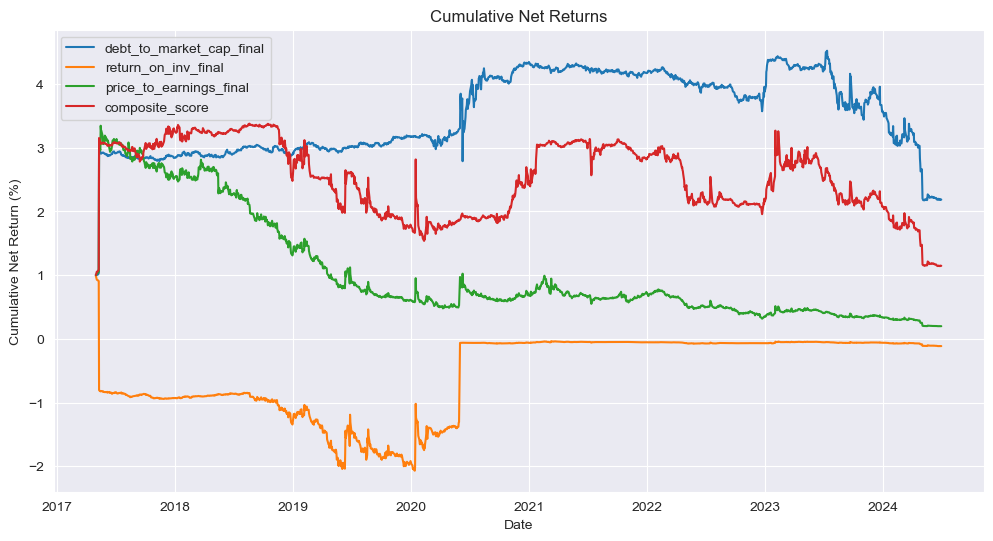

In [56]:
plot_cumulative_returns(cumulative_returns_list)

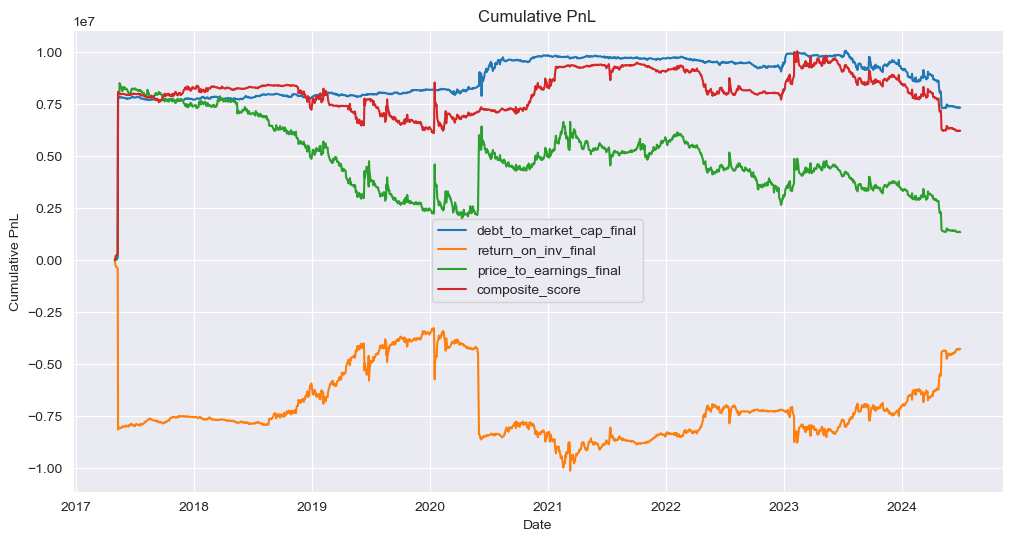

In [57]:
plot_cumulative_pnl(cumulative_pnl_list)

Monthly rebalancing is stable and better than weekly rebalancing. Debt to market cap performs better than other ratios. Composite score again closely matches price to earnings ratio

# Trading strategy on ratio changes
Initial Capital fixed  at  $1000000

In [58]:
# Function to calculate period-over-period changes
def calculate_ratio_changes(df, ratio_column):
    df_ratio = df.pivot(index='date', columns='ticker', values=ratio_column)
    df_ratio_changes = df_ratio.pct_change().fillna(0)
    return df_ratio_changes

# Modified trading pipeline
def modified_quantile_trading_pipeline(df, ratio_column, quantile=0.1,
                                       frequency='M', ascending=False,
                                       size_adjustment=None):
    df_ratio_changes = calculate_ratio_changes(df, ratio_column)
    n_ticker = df['ticker'].nunique()
    df_adj_close = get_pivot_table(df, 'adj_close')
    df_ratio_changes_rank, buy_quantile, sell_quantile  = calculate_quantiles(df_ratio_changes, n_ticker, quantile, ascending)
    df_position = generate_positions(df_ratio_changes_rank, buy_quantile, sell_quantile)

    # Adjust position sizing based on strategy
    if size_adjustment == 'double_attractive':
        vigintile = int(n_ticker / 20)  # Top and bottom 5%
        df_position = df_position.apply(lambda col:
            np.where(col.rank(method='first') <= vigintile, col * 2,
            np.where(col.rank(method='first') > n_ticker - vigintile, col * 2, col))
        )
    elif size_adjustment == 'half_attractive':
        vigintile = int(n_ticker / 20)  # Top and bottom 5%
        df_position = df_position.apply(lambda col:
            np.where(col.rank(method='first') <= vigintile, col / 2,
            np.where(col.rank(method='first') > n_ticker - vigintile, col / 2, col))
        )

    # Calculate initial capital and adjust positions
    initial_capital, capital = 1e6, 1e6/2
    df_position_adjusted = adjust_positions(df_position, df_adj_close, capital)

    # Apply rebalancing and calculate PnL
    df_position_adjusted = apply_frequency_rebalancing(df_position_adjusted, frequency)
    pnl_df = calculate_pnl_and_returns(df_position_adjusted, df_adj_close, initial_capital)

    return pnl_df

### Debt to Market Cap

In [59]:
# Example usage with different strategies
ratio_dfs = {
    'ratio_changes_no_adjustment': modified_quantile_trading_pipeline(final_df, 'debt_to_market_cap_final'),
    'ratio_changes_double_attractive': modified_quantile_trading_pipeline(final_df, 'debt_to_market_cap_final', size_adjustment='double_attractive'),
    'ratio_changes_half_attractive': modified_quantile_trading_pipeline(final_df, 'debt_to_market_cap_final', size_adjustment='half_attractive')
}

combined_metrics, cumulative_returns_list, cumulative_pnl_list = performance_metrics(ratio_dfs)


In [60]:
combined_metrics

,Mean,Vol,Sharpe,Min,Max,Max Drawdown,VaR (5%),CVaR (5%)
ratio_changes_no_adjustment,-0.000082,0.022990,-0.0036,0.527912,1.523296,-0.995384,-0.028537,-0.053815
ratio_changes_double_attractive,-0.000046,0.033632,-0.0014,0.239323,1.176303,-0.936979,-0.030189,-0.087456
ratio_changes_half_attractive,0.000187,0.019853,0.0094,0.690746,1.245465,-0.500034,-0.020459,-0.045884


In [61]:
downside_betas = calculate_all_downside_betas(ratio_dfs, spy_data)
print("Downside Betas:")
print(downside_betas)

Downside Betas:
{'ratio_changes_no_adjustment': 0.11782332754857558, 'ratio_changes_double_attractive': -0.30082488469198804, 'ratio_changes_half_attractive': -0.3702735105125948}


Adjusting position sizes enhances downside protection, with the **"half attractive" strategy** providing the strongest hedge against market declines.

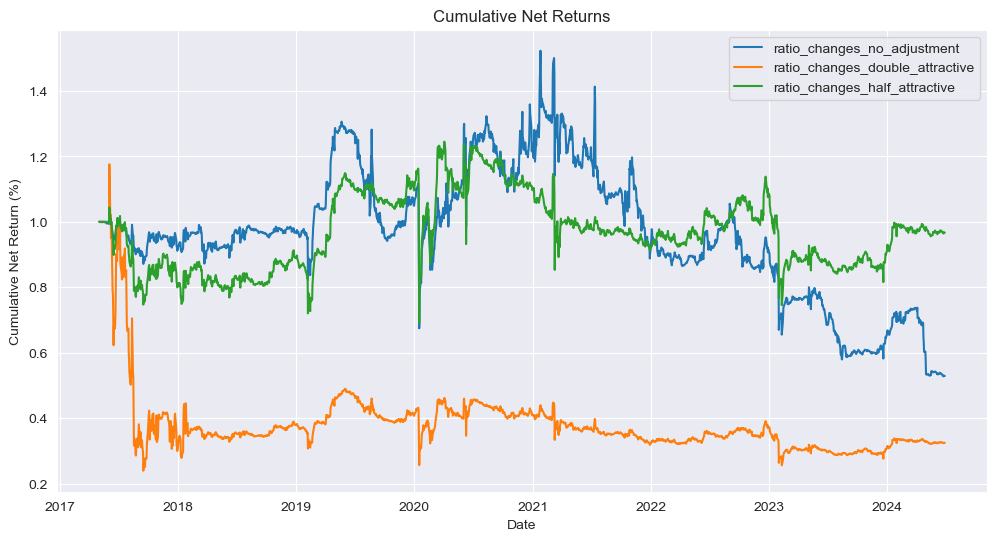

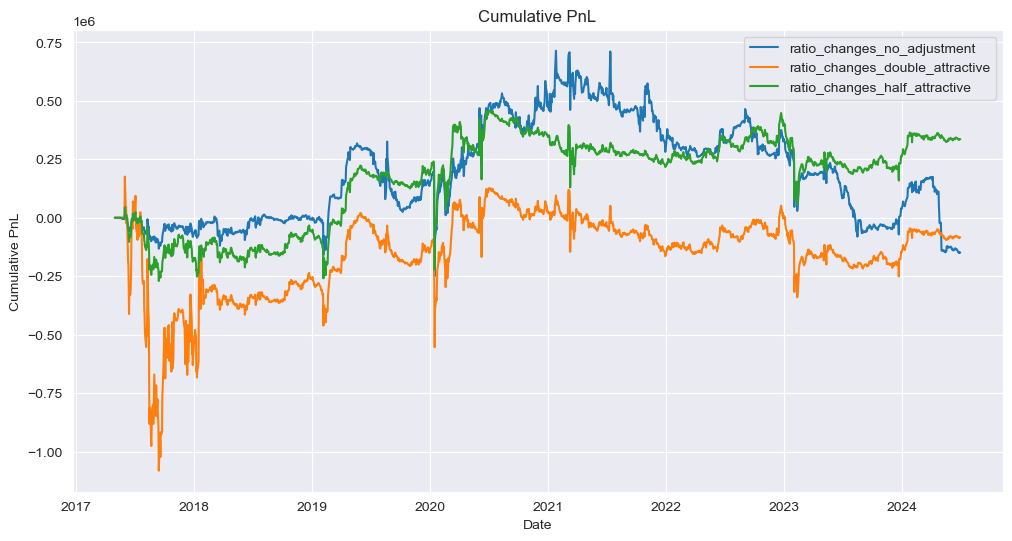

In [62]:
plot_cumulative_returns(cumulative_returns_list)
plot_cumulative_pnl(cumulative_pnl_list)

The "no adjustment" strategy delivers the highest returns but with significant volatility, while the "half attractive" strategy offers a balance between stability and performance. The "double attractive" strategy prioritizes downside protection but sacrifices returns.

### Return on Investment

In [63]:
# Example usage with different strategies
ratio_dfs = {
    'ratio_changes_no_adjustment': modified_quantile_trading_pipeline(final_df, 'return_on_inv_final'),
    'ratio_changes_double_attractive': modified_quantile_trading_pipeline(final_df, 'return_on_inv_final', size_adjustment='double_attractive'),
    'ratio_changes_half_attractive': modified_quantile_trading_pipeline(final_df, 'return_on_inv_final', size_adjustment='half_attractive')
}

combined_metrics, cumulative_returns_list, cumulative_pnl_list = performance_metrics(ratio_dfs)

In [64]:
combined_metrics

,Mean,Vol,Sharpe,Min,Max,Max Drawdown,VaR (5%),CVaR (5%)
ratio_changes_no_adjustment,0.000027,0.025419,0.0011,0.575499,1.539228,-0.963728,-0.029073,-0.057744
ratio_changes_double_attractive,-0.000080,0.035608,-0.0022,0.198723,1.176304,-0.977581,-0.035274,-0.095187
ratio_changes_half_attractive,0.000170,0.019366,0.0088,0.650743,1.196390,-0.475613,-0.020773,-0.045822


In [65]:
downside_betas = calculate_all_downside_betas(ratio_dfs, spy_data)
print("Downside Betas:")
print(downside_betas)

Downside Betas:
{'ratio_changes_no_adjustment': 0.1090718683224874, 'ratio_changes_double_attractive': -0.3513721881800512, 'ratio_changes_half_attractive': -0.4081258943764071}


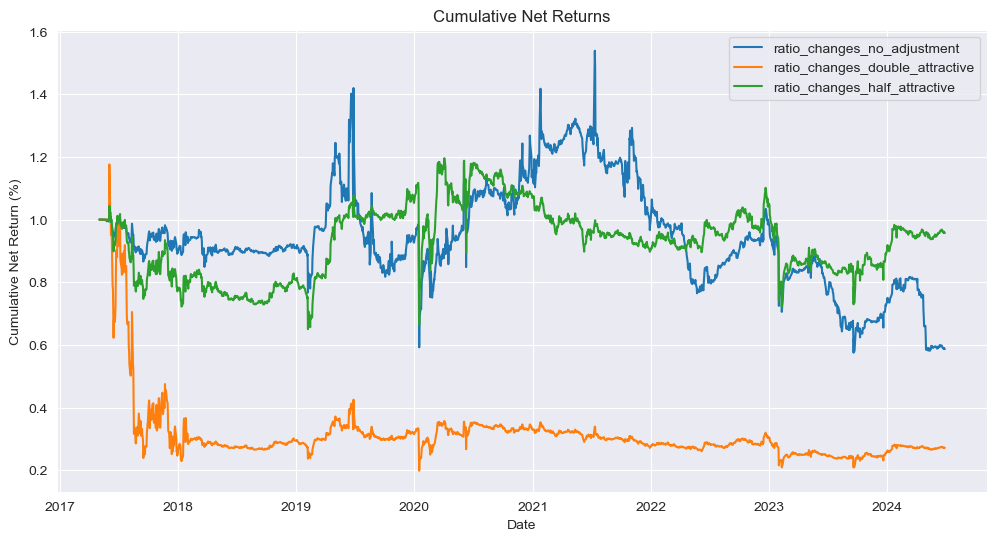

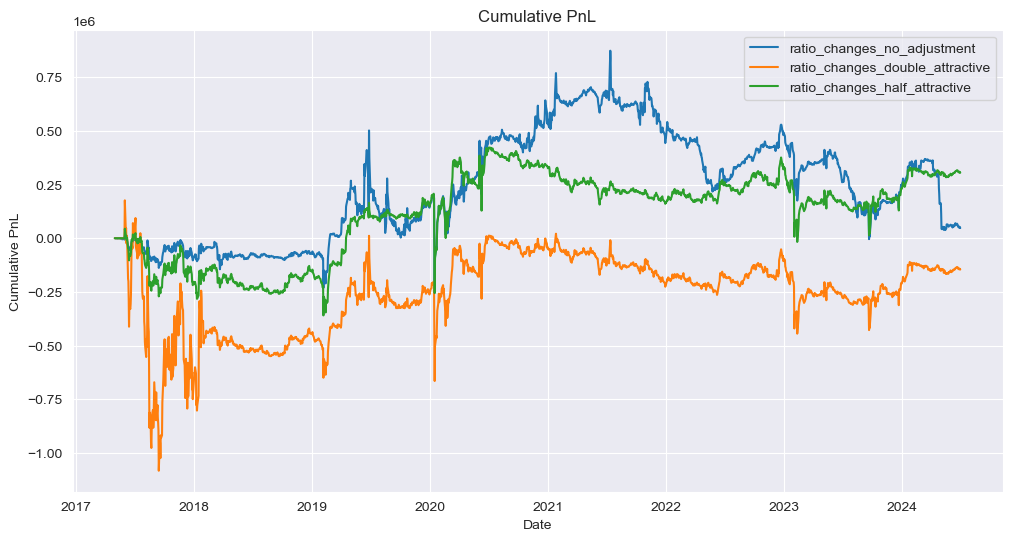

In [66]:
plot_cumulative_returns(cumulative_returns_list)
plot_cumulative_pnl(cumulative_pnl_list)

The "half attractive" strategy provides the best balance of stability and downside protection, while the "no adjustment" strategy delivers higher returns at the cost of significant volatility and market sensitivity.

### Price to Earnings

In [67]:
# Example usage with different strategies
ratio_dfs = {
    'ratio_changes_no_adjustment': modified_quantile_trading_pipeline(final_df, 'price_to_earnings_final'),
    'ratio_changes_double_attractive': modified_quantile_trading_pipeline(final_df, 'price_to_earnings_final', size_adjustment='double_attractive'),
    'ratio_changes_half_attractive': modified_quantile_trading_pipeline(final_df, 'price_to_earnings_final', size_adjustment='half_attractive')
}

combined_metrics, cumulative_returns_list, cumulative_pnl_list = performance_metrics(ratio_dfs)

In [68]:
combined_metrics

,Mean,Vol,Sharpe,Min,Max,Max Drawdown,VaR (5%),CVaR (5%)
ratio_changes_no_adjustment,0.000011,0.022233,0.0005,0.316020,1.139476,-0.823456,-0.027576,-0.051855
ratio_changes_double_attractive,0.000194,0.034622,0.0056,0.208866,2.137173,-1.928306,-0.041639,-0.086640
ratio_changes_half_attractive,0.000269,0.016965,0.0159,0.537929,1.287540,-0.749610,-0.023510,-0.041785


In [69]:
downside_betas = calculate_all_downside_betas(ratio_dfs, spy_data)
print("Downside Betas:")
print(downside_betas)

Downside Betas:
{'ratio_changes_no_adjustment': -0.08889957799249282, 'ratio_changes_double_attractive': -0.38544554433864536, 'ratio_changes_half_attractive': -0.451405757374055}


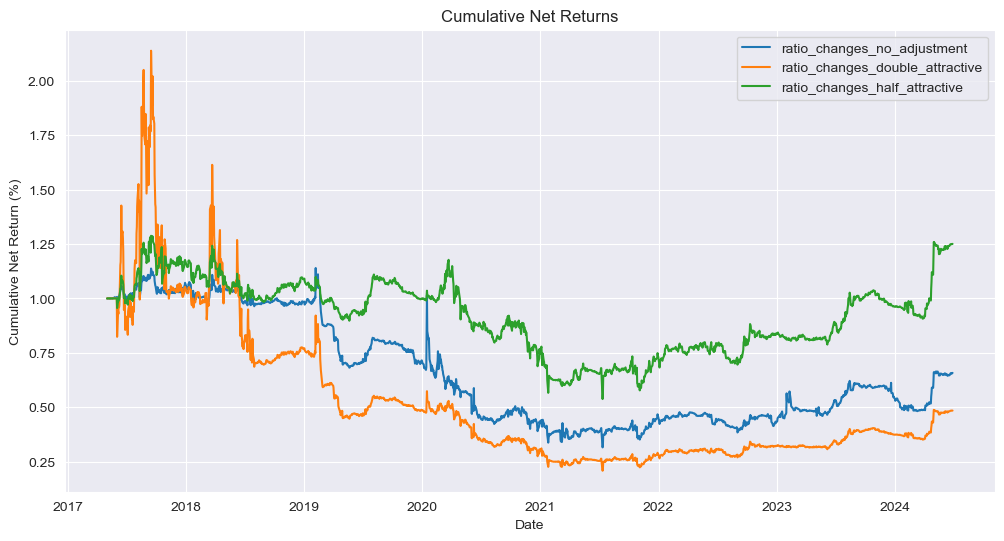

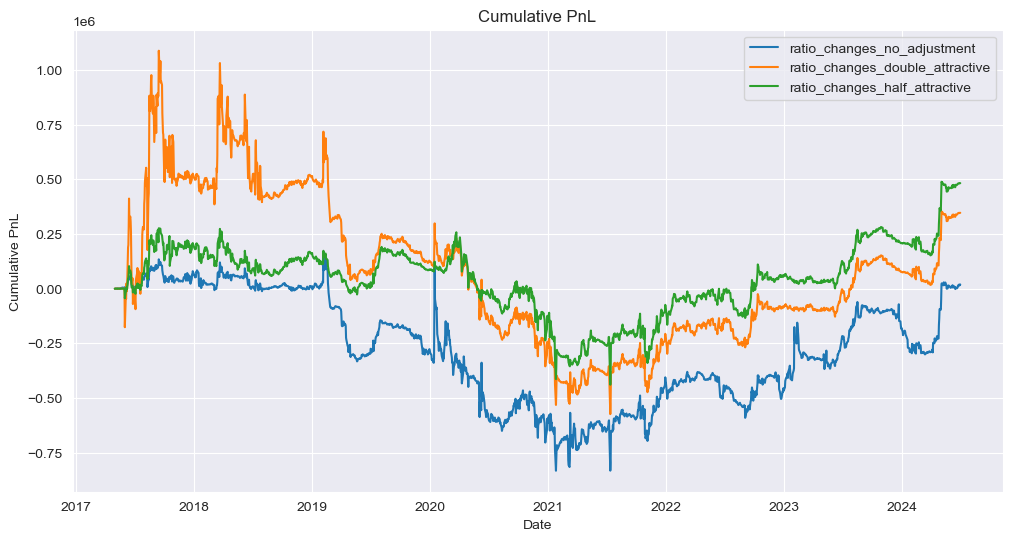

In [70]:
plot_cumulative_returns(cumulative_returns_list)
plot_cumulative_pnl(cumulative_pnl_list)

The "half attractive" strategy (green) is the best performer, combining strong cumulative returns with robust downside protection. The "double attractive" strategy sacrifices returns for hedging, while the "no adjustment" strategy offers moderate performance with limited downside sensitivity.

### Composite/Combined ratio

In [71]:
# Example usage with different strategies
ratio_dfs = {
    'ratio_changes_no_adjustment': modified_quantile_trading_pipeline(final_df, 'composite_score'),
    'ratio_changes_double_attractive': modified_quantile_trading_pipeline(final_df, 'composite_score', size_adjustment='double_attractive'),
    'ratio_changes_half_attractive': modified_quantile_trading_pipeline(final_df, 'composite_score', size_adjustment='half_attractive')
}
combined_metrics, cumulative_returns_list, cumulative_pnl_list = performance_metrics(ratio_dfs)

In [72]:
combined_metrics

,Mean,Vol,Sharpe,Min,Max,Max Drawdown,VaR (5%),CVaR (5%)
ratio_changes_no_adjustment,0.000095,0.022055,0.0043,0.714666,1.885457,-1.170790,-0.027393,-0.052484
ratio_changes_double_attractive,-0.000047,0.034357,-0.0014,0.217543,1.176310,-0.958767,-0.034566,-0.091877
ratio_changes_half_attractive,0.000194,0.019238,0.0101,0.684861,1.231062,-0.480079,-0.020572,-0.045423


In [73]:
downside_betas = calculate_all_downside_betas(ratio_dfs, spy_data)
print("Downside Betas:")
print(downside_betas)

Downside Betas:
{'ratio_changes_no_adjustment': 0.09246061230571131, 'ratio_changes_double_attractive': -0.35860982692189525, 'ratio_changes_half_attractive': -0.4095054245050312}


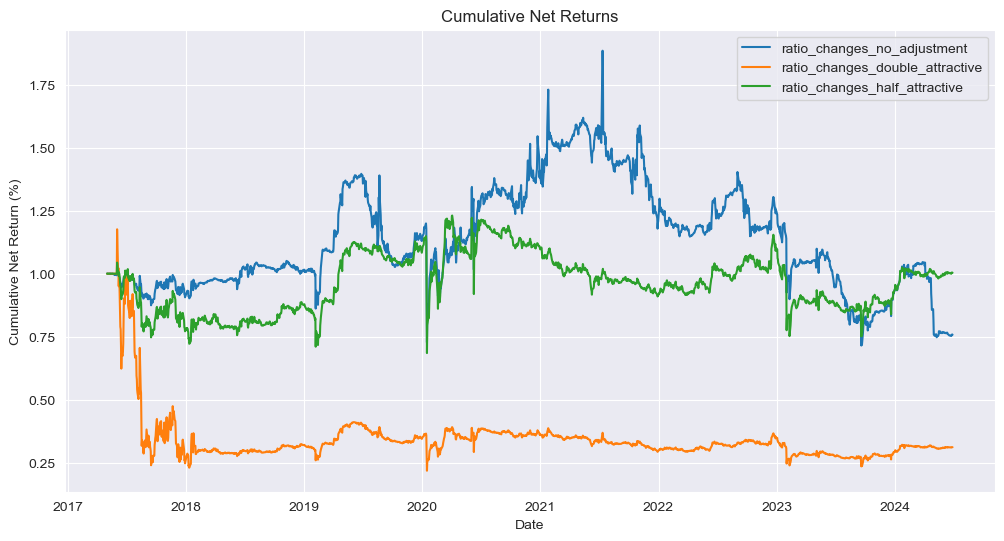

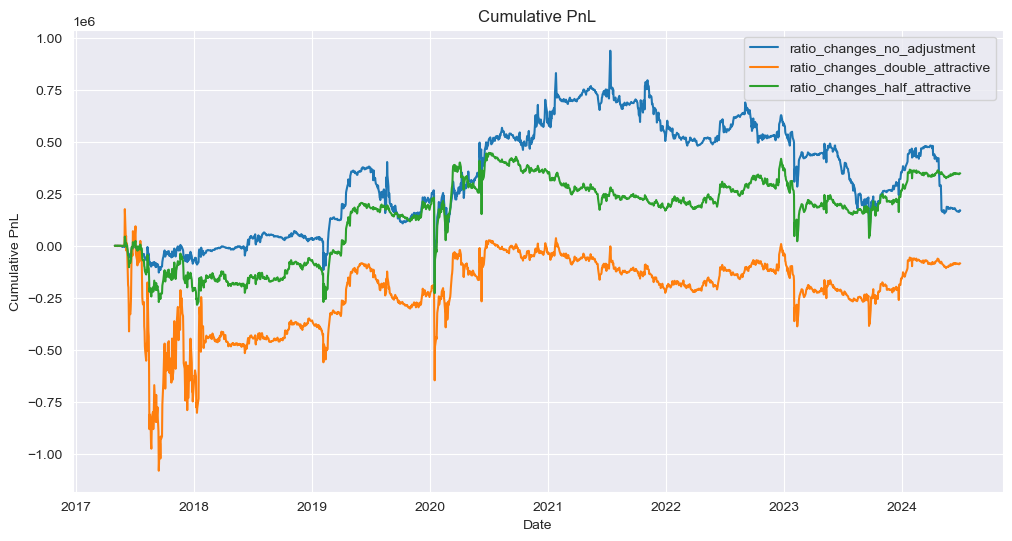

In [74]:
plot_cumulative_returns(cumulative_returns_list)
plot_cumulative_pnl(cumulative_pnl_list)

The "half attractive" strategy (green) is the most balanced, offering strong downside protection and consistent returns. The "no adjustment" strategy (blue) generates higher returns but is more volatile, while the "double attractive" strategy (orange) prioritizes downside protection at the cost of overall performance.

# Future Improvements
- Our approach gives a look-ahead bias to our combined score factor, for future use we can calculate weights by fitting past data and placing dynamic weights to our ratios (which I haven't done here). We can also perform grid search using past data for optimal weights.
- Optimize cumulative pnl and return calculation code and we can implement optimizations to different parts of code
- We can try dynamic weighing schemes for quantiles as well and calculating investment capital accordingly
- "We can analyze the relationship between our portfolio PnLs and the Fama-French factors (SMB, HML, and Mkt-RF) to better understand their correlations and how these factors influence portfolio returns during different market conditions."